<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/ms_graphrag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet langchain-community langchain-experimental langchain-openai neo4j graphdatascience tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.5/293.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [2]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

··········


In [3]:
from langchain_community.graphs import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://44.202.208.177:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "mast-codes-trails"

graph = Neo4jGraph()

In [7]:
import pandas as pd
import tiktoken


def num_tokens_from_string(string: str, model: str = "gpt-4o") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(string))
    return num_tokens


news = pd.read_csv(
    "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/news_articles.csv"
)
news["tokens"] = [
    num_tokens_from_string(f"{row['title']} {row['text']}")
    for i, row in news.iterrows()
]
news.head()

,title,date,text,tokens
0,Chevron: Best Of Breed,2031-04-06T01:36:32.000000000+00:00,JHVEPhoto Like many companies in the O&G secto...,78
1,FirstEnergy (NYSE:FE) Posts Earnings Results,2030-04-29T06:55:28.000000000+00:00,FirstEnergy (NYSE:FE – Get Rating) posted its ...,130
2,Dáil almost suspended after Sinn Féin TD put p...,2023-06-15T14:32:11.000000000+00:00,The Dáil was almost suspended on Thursday afte...,631
3,Epic’s latest tool can animate hyperrealistic ...,2023-06-15T14:00:00.000000000+00:00,"Today, Epic is releasing a new tool designed t...",528
4,"EU to Ban Huawei, ZTE from Internal Commission...",2023-06-15T13:50:00.000000000+00:00,The European Commission is planning to ban equ...,281


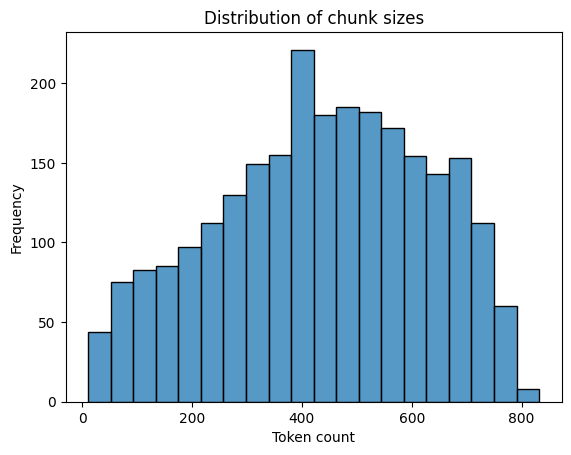

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(news["tokens"], kde=False)
plt.title('Distribution of chunk sizes')
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.show()

# Entity extraction

In [ ]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

llm_transformer = LLMGraphTransformer(llm=llm, node_properties=["description"])

In [ ]:
from typing import List
from langchain_community.graphs.graph_document import GraphDocument
from langchain_core.documents import Document

def process_text(text: str) -> List[GraphDocument]:
    doc = Document(page_content=text)
    return llm_transformer.convert_to_graph_documents([doc])

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

MAX_WORKERS = 10
NUM_ARTICLES = 250
graph_documents = []

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submitting all tasks and creating a list of future objects
    futures = [
        executor.submit(process_text, f"{row['title']} {row['text']}")
        for i, row in news.head(NUM_ARTICLES).iterrows()
    ]

    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Processing documents"
    ):
        graph_document = future.result()
        graph_documents.extend(graph_document)

graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

Processing documents: 100%|██████████| 250/250 [02:42<00:00,  1.54it/s]


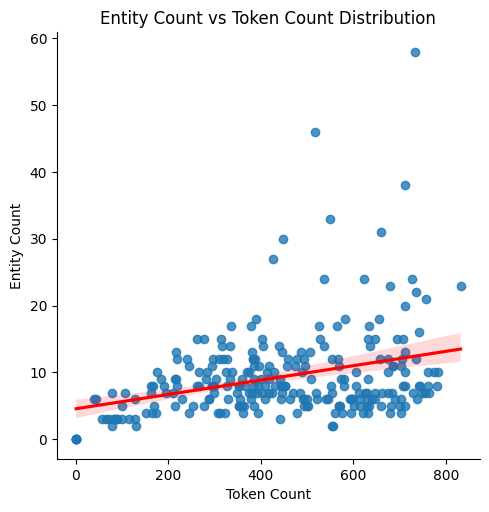

In [20]:
entity_dist = graph.query(
    """
MATCH (d:Document)
RETURN d.text AS text,
       count {(d)-[:MENTIONS]->()} AS entity_count
"""
)
entity_dist_df = pd.DataFrame.from_records(entity_dist)
entity_dist_df["token_count"] = [
    num_tokens_from_string(str(el)) for el in entity_dist_df["text"]
]
# Scatter plot with regression line
sns.lmplot(
    x="token_count", y="entity_count", data=entity_dist_df, line_kws={"color": "red"}
)
plt.title("Entity Count vs Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Entity Count")
plt.show()


In [ ]:
graph.query("""
MATCH (n:`__Entity__`)
RETURN count(*) AS entity_count,
       count(n.description) AS non_null_descriptions
""")

[{'entity_count': 1949, 'non_null_descriptions': 713}]

In [ ]:
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings

vector = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    node_label='__Entity__',
    text_node_properties=['id', 'description'],
    embedding_node_property='embedding'
)

# Entity resolution

In [ ]:
from graphdatascience import GraphDataScience
# project graph

gds = GraphDataScience(
    os.environ["NEO4J_URI"],
    auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
)

In [ ]:
G, result = gds.graph.project(
    "entities",                   #  Graph name
    "__Entity__",                 #  Node projection
    "*",                          #  Relationship projection
    nodeProperties=["embedding"]  #  Configuration parameters
)

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

In [ ]:
similarity_threshold = 0.95

gds.knn.mutate(
  G,
  nodeProperties=['embedding'],
  mutateRelationshipType= 'SIMILAR',
  mutateProperty= 'score',
  similarityCutoff=similarity_threshold
)

Knn:   0%|          | 0/100 [00:00<?, ?%/s]

ranIterations                                                            19
nodePairsConsidered                                                 1146066
didConverge                                                            True
preProcessingMillis                                                       0
computeMillis                                                         10611
mutateMillis                                                            384
postProcessingMillis                                                      0
nodesCompared                                                          1949
relationshipsWritten                                                   1206
similarityDistribution    {'min': 0.9700050354003906, 'p5': 0.9713821411...
configuration             {'mutateProperty': 'score', 'jobId': '6ad3ca35...
Name: 0, dtype: object

In [ ]:
gds.wcc.write(
    G,
    writeProperty="wcc",
    relationshipTypes=["SIMILAR"]
)

writeMillis                                                            680
nodePropertiesWritten                                                 1949
componentCount                                                        1650
componentDistribution    {'min': 1, 'p5': 1, 'max': 50, 'p999': 43, 'p9...
postProcessingMillis                                                    94
preProcessingMillis                                                      0
computeMillis                                                           74
configuration            {'writeProperty': 'wcc', 'jobId': 'a3ef4c0b-d2...
Name: 0, dtype: object

In [23]:
# Just for inspection
word_edit_distance = 3
potential_duplicate_candidates = graph.query(
    """MATCH (e:`__Entity__`)
    WITH e.wcc AS community, collect(e) AS nodes, count(*) AS count
    WHERE count > 1
    UNWIND nodes AS node
    // Add text distance
    WITH distinct
      [n IN nodes WHERE apoc.text.distance(toLower(node.id), toLower(n.id)) < $distance | n.id] AS intermediate_results
    WHERE size(intermediate_results) > 1
    WITH collect(intermediate_results) AS results
    // combine groups together if they share elements
    UNWIND range(0, size(results)-1, 1) as index
    WITH results, index, results[index] as result
    WITH apoc.coll.sort(reduce(acc = result, index2 IN range(0, size(results)-1, 1) |
            CASE WHEN index <> index2 AND
                size(apoc.coll.intersection(acc, results[index2])) > 0
                THEN apoc.coll.union(acc, results[index2])
                ELSE acc
            END
    )) as combinedResult
    WITH distinct(combinedResult) as combinedResult
    // extra filtering
    WITH collect(combinedResult) as allCombinedResults
    UNWIND range(0, size(allCombinedResults)-1, 1) as combinedResultIndex
    WITH allCombinedResults[combinedResultIndex] as combinedResult, combinedResultIndex, allCombinedResults
    WHERE NOT any(x IN range(0,size(allCombinedResults)-1,1)
        WHERE x <> combinedResultIndex
        AND apoc.coll.containsAll(allCombinedResults[x], combinedResult)
    )
    RETURN combinedResult
    """, params={'distance': word_edit_distance})
potential_duplicate_candidates[:20]

[{'combinedResult': ['Mediatek_Dimensity_9200+_Soc',
   'Mediatek_Dimensity_9200_Soc']},
 {'combinedResult': ['Star Ocean The Second Story R',
   'Star Ocean: The Second Story R']},
 {'combinedResult': ['Star Ocean First Departure R',
   'Star Ocean: First Departure R']},
 {'combinedResult': ['Silicon Valley Bank', 'Silicon_Valley_Bank']},
 {'combinedResult': ['Carmax Auto Owner Trust 2019-3',
   'Carmax Auto Owner Trust 2019-4']},
 {'combinedResult': ['U.S. Securities And Exchange Commission',
   'Us Securities And Exchange Commission']},
 {'combinedResult': ['Sky', 'Sky Q']},
 {'combinedResult': ['Sky Customers', 'Sky Q Customers']},
 {'combinedResult': ['-2.27%', '2.24%']},
 {'combinedResult': ['Sony Wf-1000Xm4', 'Sony Wf-1000Xm5']},
 {'combinedResult': ["Domino'S Pizza", 'Domino’S Pizza']},
 {'combinedResult': ['2019', '2020']},
 {'combinedResult': ['May 1', 'May 31']},
 {'combinedResult': ['August 12, 2023',
   'August 19, 2023',
   'August 26, 2023',
   'August 7, 2023']},
 {'com

In [ ]:
graph.query(
    """MATCH (e:`__Entity__`)
    WITH e.wcc AS community, collect(e) AS nodes, count(*) AS count
    WHERE count > 1
    CALL apoc.refactor.mergeNodes(nodes)
    YIELD node
    RETURN count(*)
    """)

[{'count(*)': 13}]

In [ ]:
G.drop()

graphName                                                         entities
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                             1949
relationshipCount                                                     3316
configuration            {'relationshipProjection': {'__ALL__': {'aggre...
density                                                           0.000873
creationTime                           2024-06-30T12:24:20.247497346+00:00
modificationTime                       2024-06-30T12:24:46.739007008+00:00
schema                   {'graphProperties': {}, 'nodes': {'__Entity__'...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'__Entity__'...
Name: 0, dtype: object

# Calculating communities of entities

In [ ]:
G, result = gds.graph.project(
    "entities",  #  Graph name
    "__Entity__",  #  Node projection
    {"_ALL_": {"type": "*", "orientation": "UNDIRECTED"}},
)


In [ ]:
gds.leiden.write(G, writeProperty="communities", includeIntermediateCommunities=True)

writeMillis                                                            184
nodePropertiesWritten                                                  227
ranLevels                                                                3
didConverge                                                           True
nodeCount                                                              227
communityCount                                                          44
communityDistribution    {'min': 1, 'p5': 1, 'max': 17, 'p999': 17, 'p9...
modularity                                                        0.958559
modularities             [0.8402214685204736, 0.9548415354551786, 0.958...
postProcessingMillis                                                     3
preProcessingMillis                                                      0
computeMillis                                                         1048
configuration            {'writeProperty': 'communities', 'theta': 0.01...
Name: 0, dtype: object

# Build community summaries

In [ ]:
# Create first level community nodes
graph.query("""
MATCH (e:`__Entity__`)
WITH e, '1-' + e.communities[0] AS communityId // first smaller one community
MERGE (c:Community {id:communityId})
MERGE (e)-[:PART_OF]->(c)
""")

[]

In [ ]:
community_info = graph.query("""
MATCH (e:`__Entity__`)
WITH '1-' + e.communities[0] AS communityId, collect(e) AS nodes
WHERE size(nodes) > 1
CALL apoc.path.subgraphAll(nodes[0], {
	whitelistNodes:nodes
})
YIELD relationships
RETURN communityId, [r in relationships | {start: startNode(r).id, type: type(r), end: endNode(r).id}] AS rels
""")

In [ ]:
community_info[5]

{'communityId': '1-18',
 'rels': [{'start': 'Ryanair', 'type': 'TERMINATED', 'end': 'Aidan Murray'},
  {'start': 'Ryanair', 'type': 'EMPLOYED', 'end': 'Aidan Murray'},
  {'start': 'Aidan Murray', 'type': 'REPORTED_BY', 'end': 'The Independent'},
  {'start': 'Aidan Murray', 'type': 'HARASSED', 'end': 'Ryanair'},
  {'start': 'Aidan Murray', 'type': 'TERMINATED_BY', 'end': 'Darrell Hughes'},
  {'start': 'Aidan Murray',
   'type': 'REPORTED_BY',
   'end': 'The Financial Times'},
  {'start': 'Aidan Murray', 'type': 'CONTACTED_BY', 'end': 'Bbc'},
  {'start': 'Royal Aeronautical Society',
   'type': 'REPORTED',
   'end': 'Ryanair'}]}

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

community_template = """Based on the provided triples that belong to the same graph community,
generate a natural language summary of the provided information:
{community_info}

Summary:"""  # noqa: E501

community_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Given an input triples, generate the information summary. No pre-amble.",
        ),
        ("human", community_template),
    ]
)

community_chain = community_prompt | llm | StrOutputParser()

In [ ]:
def process_community(community):
    stringify_info = "\n".join([f"{el['start']}-{el['type']}->{el['end']}" for el in community['rels']])
    summary = community_chain.invoke({'community_info': stringify_info})
    return {"community": community['communityId'], "summary": summary}

summaries = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_community, community): community for community in community_info}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing communities"):
        summaries.append(future.result())

Processing communities: 100%|██████████| 63/63 [00:10<00:00,  6.00it/s]


In [ ]:
# Store summaries
graph.query("""
UNWIND $data AS row
MERGE (c:Community {id:row.community})
SET c.summary = row.summary
""", params={"data": summaries})

[]

In [ ]:
# Do higher level communities...
graph.query("""
MATCH (e:`__Entity__`)
WITH e, '1-' + e.communities[0] AS communityId1, '2-' + e.communities[-1] AS communityId2
WITH distinct communityId1, communityId2
MATCH (c:Community {id: communityId1})
MERGE (c1:Community {id: communityId2})
MERGE (c)-[:PART_OF]->(c1)
""")

[]

In [ ]:
community_info = graph.query("""
MATCH (e:`__Entity__`)
WITH '2-' + e.communities[-1] AS communityId, collect(e) AS nodes
WHERE size(nodes) > 1
CALL apoc.path.subgraphAll(nodes[0], {
	whitelistNodes:nodes
})
YIELD relationships
RETURN communityId, [r in relationships | {start: startNode(r).id, type: type(r), end: endNode(r).id}] AS rels
""")

In [ ]:
summaries = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_community, community): community for community in community_info}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing communities"):
        summaries.append(future.result())

Processing communities: 100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


In [ ]:
# Store summaries
graph.query("""
UNWIND $data AS row
MERGE (c:Community {id:row.community})
SET c.summary = row.summary
""", params={"data": summaries})

[]

In [ ]:
# Calculate embeddings
community_vector = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    index_name="summariesIndex",
    node_label='Community',
    text_node_properties=['summary'],
    embedding_node_property='embedding'
)

In [ ]:
community_vector.similarity_search("What's the deal with EU and Huawei?", k=1)

[Document(page_content='\nsummary: The European Union considers Huawei Technologies Co. and Zte Corp. to be high-risk entities. Additionally, the European Union has imposed bans on Tiktok Inc., Zte Corp., and Huawei Technologies Co. Alberto Nardelli and Thomas Seal have both provided assistance to the European Union.')]

* repeat for larger community
* maybe connect community summaries to sth
* put a QA chain on top of